In [16]:
dir.create(paste0(getwd(),"/R_libs/"))

In [19]:
install.packages(c("startR","s2dv","multiApply","s2dverification","ClimProjDiags","RColorBrewer","CSTools"),
                 destdir=(paste0(getwd(),"/R_libs/")),
                         lib=(paste0(getwd(),"/R_libs/")))


In [20]:
.libPaths(paste0(getwd(),"/R_libs/"))

In [21]:
library(startR)
library(s2dv)
library(multiApply)
library(s2dverification)
library(ClimProjDiags)
library(RColorBrewer)
library(CSTools)

ERROR: Error: package or namespace load failed for ‘startR’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 there is no package called ‘easyNCDF’


In [12]:
.libPaths()

[1] "/srv/rlibs"                    "/usr/local/lib/R/site-library"
[3] "/usr/lib/R/site-library"       "/usr/lib/R/library"

In [8]:
getwd()

[1] "/home/jovyan"

In [2]:
ncores <- 1
retrieve <- TRUE
lons.min <- -20
lons.max <- 55
lats.min <- -40
lats.max <- 40
# Declaration of data sources
var_name = 'tasmax'
methods <- c('raw','bias','evmos','mse_min','crps_min','rpc-based')
exp_path <- '/esarchive/exp/ecmwf/system5c3s/monthly_mean/$var$_f24h/$var$_$sdate$01.nc'
grid <- '/esarchive/exp/ecmwf/system5c3s/monthly_mean/prlr_s0-24h/prlr_20000501.nc'
exp <- startR::Start(dat = exp_path,
                     var = var_name,
                     sdate = c("200011","200111","200211","200311"),
                     ensemble = 'all',
                     time = indices(1:6),
                     latitude = values(list(lats.min, lats.max)),
                     latitude_reorder = Sort(decreasing = T),
                     longitude = values(list(lons.min, lons.max)),
                     longitude_reorder = CircularSort(-180,180),
                     transform = CDORemapper,
		     transform_extra_cells = 8,
                     transform_params = list(grid = grid,
                                             method = 'conservative',
                                             crop = c(lons.min, lons.max, lats.min, lats.max)),
                     transform_vars = c('latitude', 'longitude'),
                     synonims = list(latitude = c('lat', 'latitude'),
                                     longitude = c('lon', 'longitude')),
                     return_vars = list(latitude = 'dat',
                                        longitude = 'dat',
                                        time = 'sdate'),
                    retrieve = retrieve)

dates <- attr(exp, 'Variables')$common$time
obs_path <- '/esarchive/recon/ecmwf/era5/monthly_mean/$var$_f24h/$var$_$date$.nc'
#dates <- format(dates, '%Y%m')
dates_file <- format(dates, '%Y%m')
dim(dates_file) <- list(sdate = 4,
                  time = 6)
obs <- Start(dat = obs_path,
             var = var_name,
           #  date = unique(format(dates, '%Y%m')),
             date = dates_file,
           #  time = values(dates),
             latitude = values(list(lats.min, lats.max)),
             latitude_reorder = Sort(decreasing = T),
             longitude = values(list(lons.min, lons.max)),
             longitude_reorder = CircularSort(-180,180),
             synonims = list(longitude = c('lon', 'longitude'),
                             latitude = c('lat', 'latitude')),
             transform = CDORemapper,
             transform_extra_cells = 8,
             transform_params = list(grid = grid,
                                     method = 'conservative',
                                     crop = c(lons.min, lons.max, lats.min, lats.max)),
             transform_vars = c('latitude', 'longitude'),
             split_multiselected_dims = TRUE,
         #    time_across = 'date',
          #   merge_across_dims = TRUE,
             return_vars = list(time = 'date',
                                latitude = 'dat',
                                longitude = 'dat'),
            retrieve = retrieve)

Warning message:
“! Warning: Parameter 'pattern_dims' not specified. Taking the first dimension,
!   'dat' as 'pattern_dims'.”
Warning message:
“! Warning: Could not find any pattern dim with explicit data set descriptions (in
!   the form of list of lists). Taking the first pattern dim, 'dat', as
!   dimension with pattern specifications.”
* Exploring files... This will take a variable amount of time depending
*   on the issued request and the performance of the file server...

Warning message:
“! Warning: Found specified values for dimension 'latitude' but no 'latitude_var'
!   requested. "latitude_var = 'latitude'" has been automatically added
!   to the Start call.”
Warning message:
“! Warning: Found specified values for dimension 'longitude' but no 'longitude_var'
!   requested. "longitude_var = 'longitude'" has been automatically
!   added to the Start call.”
Warning message in (function (data_array, variables, file_selectors = NULL, crop_domain = NULL, :
“Argument 'crop' in 'tra

In [4]:
#Function
skill_calibration <- function(exp, obs, methods) {
  
  library(s2dv)
  library(CSTools)
  library(multiApply)
  
  # source('/esarchive/scratch/ptrascas/gitlab/pasdfasdf/correlation_eno.R')
  correlation_eno <- function(exp, obs, time_dim = 'sdate', member_dim = 'ensemble', alpha = 0.05){
    
    exp <- s2dv::MeanDims(data = exp, dims = member_dim, na.rm = FALSE)
    
    cor = NULL
    cor$r = cor(exp,obs) # Correlation coefficient
    
    n_eff = s2dv::Eno(data = obs, time_dim = time_dim, na.action = na.pass, ncores = 1)
    t_alpha2_n2 = qt(p=alpha/2, df = n_eff-2, lower.tail = FALSE)
    t = abs(cor$r) * sqrt(n_eff-2) / sqrt(1-cor$r^2)
    
    if (anyNA(c(t,t_alpha2_n2)) == FALSE & t >= t_alpha2_n2){
      cor$sign = TRUE
    } else {
      cor$sign = FALSE
    }
    
    return(cor)
  }
  
  exp <- s2dv::MeanDims(data = exp, dims = 'time', na.rm = FALSE)
  obs <- s2dv::MeanDims(data = obs, dims = 'time', na.rm = FALSE)
  
  # Create an empty list that will contain the output of the "wrap_cal":
  # One list per calibration method, with the different statistical metrics embedded on it
  metrics  <- list()
  calibrated <- list() #, rpss = NULL)
  # Loop over each calibration method to calculate its metrics
  for (method in methods){
    
    if (!identical(method,'raw')){
      # Calibration function

      calibrated[[method]] <- CSTools::Calibration(exp = exp, obs = obs, cal.method = method, eval.method = "leave-one-out",
     multi.model = FALSE, na.fill = TRUE, na.rm = FALSE, memb_dim = 'ensemble', sdate_dim = 'sdate', apply_to = 'sign', alpha = 0.1, ncores = ncores)
         
    
    
    } else {
      calibrated[[method]] <- exp
    }

    # Metrics for each method
    metrics$acc[[method]] <- correlation_eno(exp = calibrated[[method]], obs = obs, time_dim = 'sdate', member_dim = 'ensemble', alpha = 0.05)
  }
  return(list(raw_calib = s2dv::Reorder(data = calibrated$raw, order = c('sdate','ensemble')),
	      acc_raw_r = metrics$acc$raw$r,
              acc_raw_sign = metrics$acc$raw$sign,
              bias_calib = s2dv::Reorder(data = calibrated$bias, order = c('sdate', 'ensemble')),
	      acc_bias_r = metrics$acc$bias$r,
              acc_bias_sign = metrics$acc$bias$sign,
              evmos_calib = s2dv::Reorder(data = calibrated$evmos, order = c('sdate', 'ensemble')),
	      acc_evmos_r = metrics$acc$evmos$r,
              acc_evmos_sign = metrics$acc$evmos$sign,
              mse_min_calib = s2dv::Reorder(data = calibrated$mse_min,order = c('sdate', 'ensemble')),
              acc_mse_min_r = metrics$acc$mse_min$r,
              acc_mse_min_sign = metrics$acc$mse_min$sign,
              crps_min_calib = s2dv::Reorder(data = calibrated$crps_min,order = c('sdate', 'ensemble')),
	      acc_crps_min_r = metrics$acc$crps_min$r,
              acc_crps_min_sign = metrics$acc$crps_min$sign,
              rpc_based_calib = s2dv::Reorder(data = calibrated[['rpc-based']],order = c('sdate', 'ensemble')),
	      acc_rpc_based_r = metrics$acc[['rpc-based']]$r,
              acc_rpc_based_sign = metrics$acc[['rpc-based']]$sign))    
    
}

  ## for one grid point
  # metrics <- skill_calibration(exp = drop(exp), obs = drop(obs), methods=methods)
  ## paralelised
output <- multiApply::Apply(data = list(exp = exp, obs = obs), target_dims = list(exp = c('sdate','ensemble','time'), 
                                                obs = c('sdate','time')), fun = skill_calibration, methods=methods, ncores = ncores)

lat <- as.numeric(attr(obs,'Variables')$dat1$latitude)
lon <- as.numeric(attr(obs,'Variables')$dat1$longitude)



In [ ]:
#Function
skill_calibration <- function(exp, obs, methods) {
  
  library(s2dv)
  library(CSTools)
  library(multiApply)
  
  # source('/esarchive/scratch/ptrascas/gitlab/pasdfasdf/correlation_eno.R')
  correlation_eno <- function(exp, obs, time_dim = 'sdate', member_dim = 'ensemble', alpha = 0.05){
    
    exp <- s2dv::MeanDims(data = exp, dims = member_dim, na.rm = FALSE)
    
    cor = NULL
    cor$r = cor(exp,obs) # Correlation coefficient
    
    n_eff = s2dv::Eno(data = obs, time_dim = time_dim, na.action = na.pass, ncores = 1)
    t_alpha2_n2 = qt(p=alpha/2, df = n_eff-2, lower.tail = FALSE)
    t = abs(cor$r) * sqrt(n_eff-2) / sqrt(1-cor$r^2)
    
    if (anyNA(c(t,t_alpha2_n2)) == FALSE & t >= t_alpha2_n2){
      cor$sign = TRUE
    } else {
      cor$sign = FALSE
    }
    
    return(cor)
  }
  
  exp <- s2dv::MeanDims(data = exp, dims = 'time', na.rm = FALSE)
  obs <- s2dv::MeanDims(data = obs, dims = 'time', na.rm = FALSE)
  
  # Create an empty list that will contain the output of the "wrap_cal":
  # One list per calibration method, with the different statistical metrics embedded on it
  metrics  <- list()
  calibrated <- list() #, rpss = NULL)
  # Loop over each calibration method to calculate its metrics
  for (method in methods){
    
    if (!identical(method,'raw')){
      # Calibration function

      calibrated[[method]] <- CSTools::Calibration(exp = exp, obs = obs, cal.method = method, eval.method = "leave-one-out",
     multi.model = FALSE, na.fill = TRUE, na.rm = FALSE, memb_dim = 'ensemble', sdate_dim = 'sdate', apply_to = 'sign', alpha = 0.1, ncores = ncores)
         
    
    
    } else {
      calibrated[[method]] <- exp
    }

    # Metrics for each method
    metrics$acc[[method]] <- correlation_eno(exp = calibrated[[method]], obs = obs, time_dim = 'sdate', member_dim = 'ensemble', alpha = 0.05)
  }
  return(list(raw_calib = s2dv::Reorder(data = calibrated$raw, order = c('sdate','ensemble')),
	      acc_raw_r = metrics$acc$raw$r,
              acc_raw_sign = metrics$acc$raw$sign,
              bias_calib = s2dv::Reorder(data = calibrated$bias, order = c('sdate', 'ensemble')),
	      acc_bias_r = metrics$acc$bias$r,
              acc_bias_sign = metrics$acc$bias$sign,
              evmos_calib = s2dv::Reorder(data = calibrated$evmos, order = c('sdate', 'ensemble')),
	      acc_evmos_r = metrics$acc$evmos$r,
              acc_evmos_sign = metrics$acc$evmos$sign,
              mse_min_calib = s2dv::Reorder(data = calibrated$mse_min,order = c('sdate', 'ensemble')),
              acc_mse_min_r = metrics$acc$mse_min$r,
              acc_mse_min_sign = metrics$acc$mse_min$sign,
              crps_min_calib = s2dv::Reorder(data = calibrated$crps_min,order = c('sdate', 'ensemble')),
	      acc_crps_min_r = metrics$acc$crps_min$r,
              acc_crps_min_sign = metrics$acc$crps_min$sign,
              rpc_based_calib = s2dv::Reorder(data = calibrated[['rpc-based']],order = c('sdate', 'ensemble')),
	      acc_rpc_based_r = metrics$acc[['rpc-based']]$r,
              acc_rpc_based_sign = metrics$acc[['rpc-based']]$sign))    
    
}

  ## for one grid point
  # metrics <- skill_calibration(exp = drop(exp), obs = drop(obs), methods=methods)
  ## paralelised
output <- multiApply::Apply(data = list(exp = exp, obs = obs), target_dims = list(exp = c('sdate','ensemble','time'), 
                                                obs = c('sdate','time')), fun = skill_calibration, methods=methods, ncores = ncores)

lat <- as.numeric(attr(obs,'Variables')$dat1$latitude)
lon <- as.numeric(attr(obs,'Variables')$dat1$longitude)



# 1) Calibrated forecast

The function we have used applies different types of bias correction methods:

- **bias** applies a simple bias correction, where the observed climatology is added  
    to the anomalies of each forecast member.

- **evmos** applies a variance inflation technique to ensure the correction of the bias 
    and the correspondence of variance between forecast and observation 
    (*Van Schaeybroeck and Vannitsem, 2011*).
  
- **mse_min** minimizes a cronstrained mean-squared error using three parameters 
    to correct the bias, the overall forecast variance and ensemble spread 
    (*Doblas-Reyes et al. 2005*).

- **crps_min** features four parameters and minimizes de Continous Ranked 
    Probability Score (CRPS) (*Van Schaeybroeck and Vannitsem, 2015*).

- **rpc-based** adjusts the forecast variance ensuring that the ratio of predictable 
    components (RCP) is equal to one (*Eade et al. 2014*).


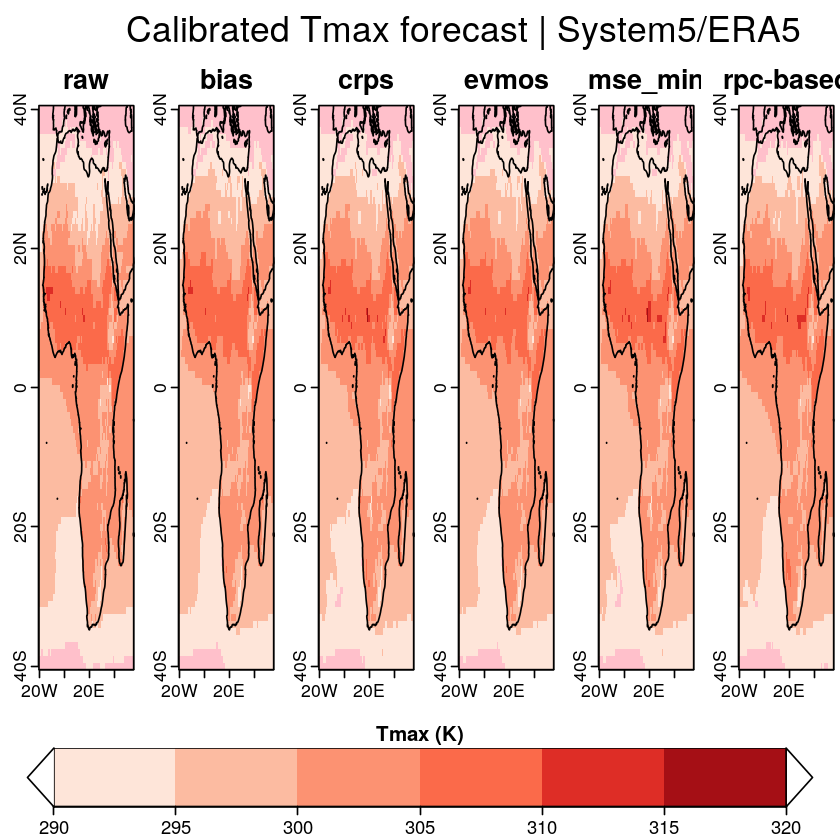

In [9]:
PlotLayout(PlotEquiMap,plot_dims = c("latitude", "longitude"), 
           var = list((output$raw_calib[mean(1:4),mean(1:25),,,,]),(output$bias_calib[mean(1:4),mean(1:25),,,,]),
                      (output$crps_min_calib[mean(1:4),mean(1:25),,,,]),(output$evmos_calib[mean(1:4),mean(1:25),,,,]),
                      (output$mse_min_calib[mean(1:4),mean(1:25),,,,]),(output$rpc_based_calib[mean(1:4),mean(1:25),,,,])),
                        lon = lon,lat = lat,title_scale = 0.7,toptitle ="Calibrated Tmax forecast | System5/ERA5",ncol=6,nrow=1,
                           bar_limits=c(290,320),cols = brewer.pal(n=6,name='Reds'),
                           titles = c("raw","bias","crps","evmos","mse_min","rpc-based"),
                           units=("Tmax (K)"),filled.continents = FALSE,triangle_ends = c(TRUE,TRUE),width = 206, height = 6, res = 1000)

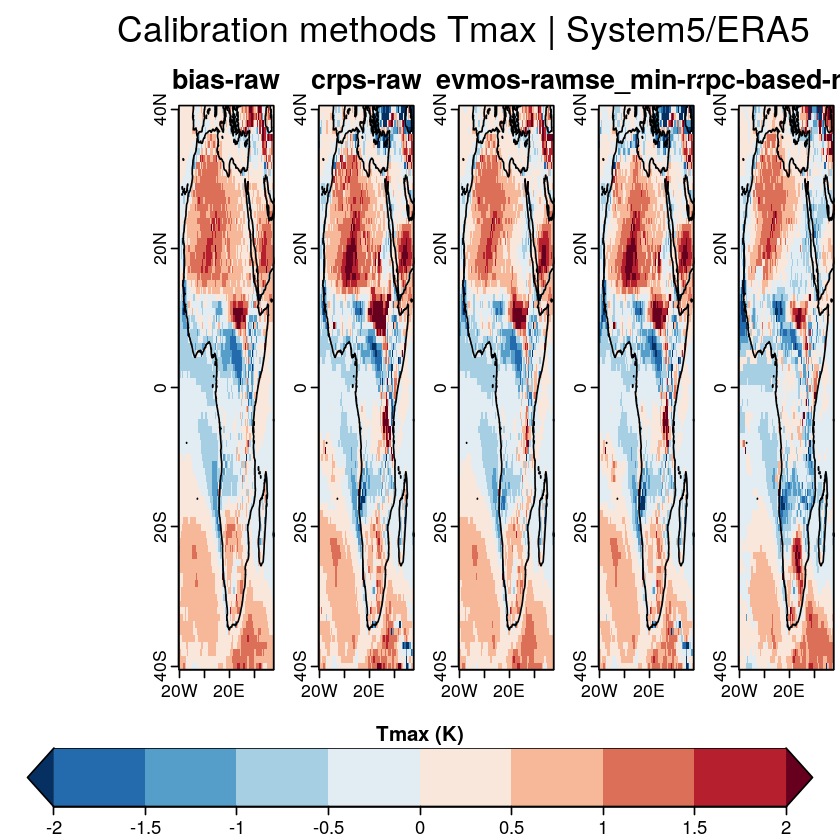

In [31]:
PlotLayout(PlotEquiMap,plot_dims = c("latitude", "longitude"), 
           var = list(NA,(output$bias_calib[mean(1:7),mean(1:25),,,,])-(output$raw_calib[mean(1:7),mean(1:25),,,,]),
                      (output$crps_min_calib[mean(1:7),mean(1:25),,,,])-(output$raw_calib[mean(1:7),mean(1:25),,,,]),
                      (output$evmos_calib[mean(1:7),mean(1:25),,,,])-(output$raw_calib[mean(1:7),mean(1:25),,,,]),
                     (output$mse_min_calib[mean(1:7),mean(1:25),,,,])-(output$raw_calib[mean(1:7),mean(1:25),,,,]),
                      (output$rpc_based_calib[mean(1:7),mean(1:25),,,,])-(output$raw_calib[mean(1:7),mean(1:25),,,,])),
                        lon = lon,lat = lat,
                           title_scale = 0.7,toptitle ="Calibration methods Tmax | System5/ERA5",ncol=6,nrow=1,
                           brks=seq(-2,2,0.5),titles = c("raw","bias-raw","crps-raw","evmos-raw","mse_min-raw","rpc-based-raw"),
                           width = 20, height = 200, dot_symbol = 20, dot_size = 2, units=("Tmax (K)"),
                            filled.continents = FALSE)

# 2) Display skill of the different calibration methods

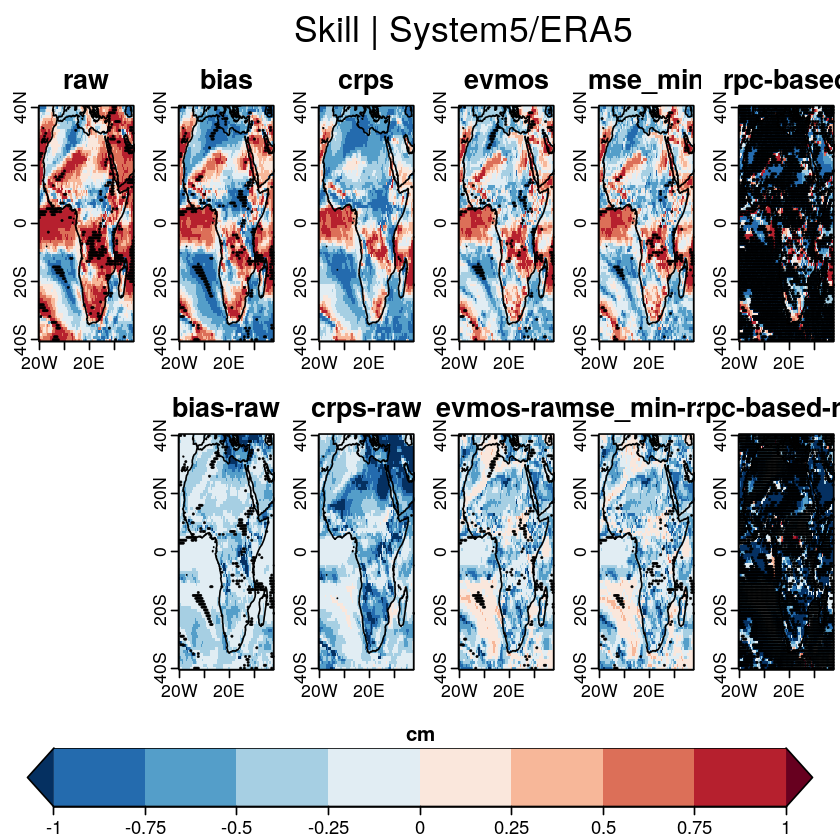

In [41]:
# s2dv::PlotEquiMap() # one map
PlotLayout(PlotEquiMap,plot_dims = c("latitude", "longitude"), 
           var = list((output[[2]]),(output[[5]]),(output[[8]]),
                      (output[[11]]),(output[[14]]),(output[[17]]),NA,(output[[5]]-output[[2]]),
                      (output[[8]]-output[[2]]),(output[[11]]-output[[2]]),
                     (output[[14]]-output[[2]]),(output[[17]]-output[[2]])),
                        lon = lon,lat = lat, 
           special_args = list(list(dots=drop(output$acc_raw_sign)),list(dots=drop(output$acc_bias_sign)),
                               list(dots=drop(output$acc_crps_sign)),list(dots=drop(output$acc_evmos_sign)),
                               list(dots=drop(output$acc_mse_min_sign)),list(dots=drop(output$acc_rpc_based_sign)),list(NA),
                               list(dots=drop(output$acc_bias_sign)),
                               list(dots=drop(output$acc_crps_sign)),list(dots=drop(output$acc_evmos_sign)),
                               list(dots=drop(output$acc_mse_min_sign)),list(dots=drop(output$acc_rpc_based_sign))),
                           title_scale = 0.7,toptitle ="Skill | System5/ERA5",ncol=6,nrow=2,
                           brks=seq(-1,1,0.25),titles = c("raw","bias","crps","evmos","mse_min","rpc-based",
                                                         "raw","bias-raw","crps-raw","evmos-raw","mse_min-raw","rpc-based-raw"),
                           dot_symbol = 20, dot_size = 1, filled.continents = FALSE,units="cm")

List of 18
 $ raw_calib         : num [1:4, 1:25, 1, 1, 1:81, 1:76] 288 289 288 289 289 ...
 $ acc_raw_r         : num [1, 1, 1:81, 1:76] -0.7645 -0.3518 -0.0494 -0.2009 -0.3031 ...
 $ acc_raw_sign      : logi [1, 1, 1:81, 1:76] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ bias_calib        : num [1:4, 1:25, 1, 1, 1:81, 1:76] 289 289 289 289 289 ...
 $ acc_bias_r        : num [1, 1, 1:81, 1:76] -0.954 -0.711 -0.393 -0.437 -0.48 ...
 $ acc_bias_sign     : logi [1, 1, 1:81, 1:76] TRUE FALSE FALSE FALSE FALSE FALSE ...
 $ evmos_calib       : num [1:4, 1:25, 1, 1, 1:81, 1:76] 288 289 289 289 289 ...
 $ acc_evmos_r       : num [1, 1, 1:81, 1:76] -0.951 -0.728 -0.465 -0.513 -0.573 ...
 $ acc_evmos_sign    : logi [1, 1, 1:81, 1:76] TRUE FALSE FALSE FALSE FALSE FALSE ...
 $ mse_min_calib     : num [1:4, 1:25, 1, 1, 1:81, 1:76] 289 289 289 289 289 ...
 $ acc_mse_min_r     : num [1, 1, 1:81, 1:76] -0.785 -0.556 -0.329 -0.437 -0.536 ...
 $ acc_mse_min_sign  : logi [1, 1, 1:81, 1:76] FALSE FALSE FAL

# 3) RPSS 

A probabilistic metric that assesses the ability of the prediction to predict categories, in this case tercile categories (below/average/above average). 

It compares the probabilistic prediction against a reference prediction, which is the expected climatological value (33% probability for each category). 

A positive RPSS indicates  the prediction is better than the climatology while a negative CRPSS indicates that the prediction is worse than the climatology.



In [54]:
library(easyVerification)
library(SpecsVerification)
library(startR)

# Define function (applied on the essential 'target' dimensions)

compute_scores <- function(exp, obs) {
  my.prob<-c(1/3,2/3)
  my.EnsRpss <- veriApply("EnsRpss", fcst=exp, obs=obs,
                           prob=my.prob, tdim=1, ensdim=2, na.rm=TRUE)[[1]]
  dim(my.EnsRpss) <- c(score = length(my.EnsRpss))
  return(my.EnsRpss)
}

rpss <- multiApply::Apply(data = list(exp = exp, obs = obs),
                         target_dims = list(exp=c('sdate','ensemble'),
                                           obs=c('sdate')),
                          output_dims = list(my.EnsRpss = 'score'),
                         fun = compute_scores, ncores = 1)


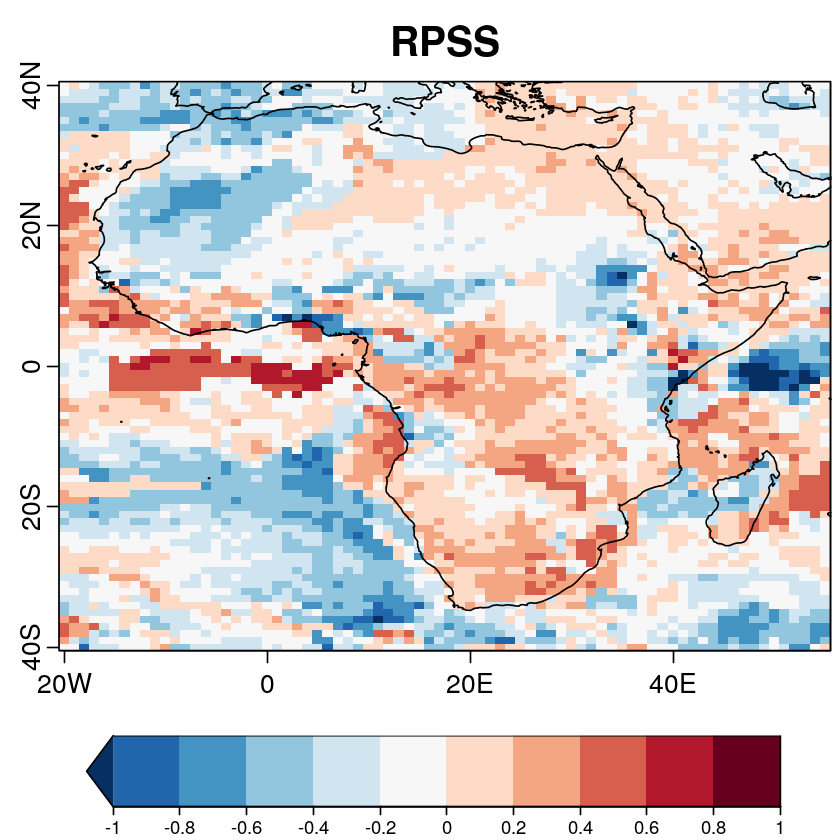

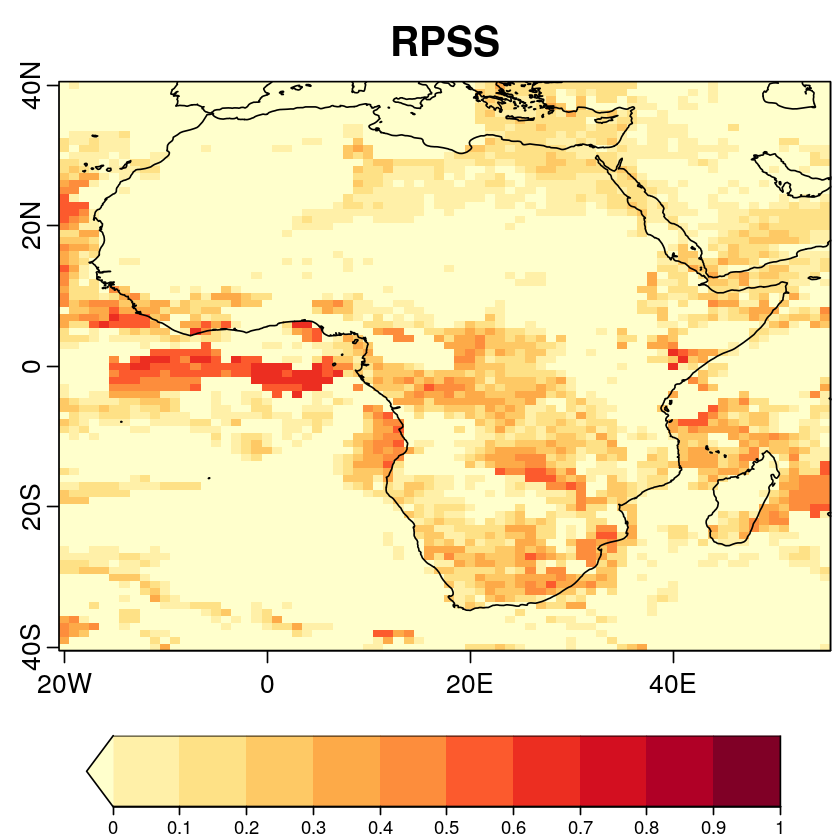

In [70]:
 PlotEquiMap(var = rpss$my.EnsRpss[,,,mean(1:6),,], lon,lat,filled.continents = FALSE, brks=seq(-1,1,0.2),toptitle='RPSS')
brks <- seq(0,1, length.out = 11)
PlotEquiMap(var=rpss$my.EnsRpss[,,,mean(1:6),,], lon,lat,
            color_fun = clim.palette('yellowred'), brks = brks,
              filled.continents = FALSE, triangle_ends = c(TRUE, FALSE),
              toptitle = 'RPSS')

# 4) Continuous Ranked Probability Skill Score (CRPSS)

A probabilistic metric that assesses the full probability distribution of the ensemble members of the prediction.

It compares the probabilistic prediction against a reference prediction, which is the expected climatological value. 

A positive CRPSS indicates  the prediction is better than the climatology *while* a negative CRPSS indicates that the 
prediction is worse than the climatology.


In [74]:
library(easyVerification)
library(SpecsVerification)
library(startR)

# Define function (applied on the essential 'target' dimensions)

crpss<- SpecsVerification::EnsCrpss(ens = exp,obs = obs)

#crpss <- multiApply::Apply(data = list(exp = exp, obs = obs),
#                         target_dims = list(exp=c('sdate','ensemble'),
#                                           obs=c('sdate')),
#                          output_dims = list(my.EnsRpss = 'score'),
#                         fun = compute_scores, ncores = 1)


ERROR: Error in EnsCrps(ens, obs): is.matrix(ens) is not TRUE
